In [1]:
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score #ordinary linear regression + w/ ridge regularization
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def get_metrics(m):
    y_predict = m.predict(X_test_scaled)
    print("Model name:",m)
    print("Default threshold:")
    print("Score: {:6.4f}, Precision: {:6.4f}, Recall: {:6.4f}, F1: {:6.4f}".format(m.score(X_test_scaled, ytest),
                                                                                    precision_score(ytest, y_predict), 
                                                                                    recall_score(ytest, y_predict),
                                                                                    f1_score(ytest, y_predict)))

**1. Load the data**

In [3]:
Xy = pd.read_pickle('data_for_regression_20k.pkl')

In [20]:
Xy.shape

(21366, 64)

In [4]:
y_bi = Xy['country_USA_World_bi']
y_mlt = Xy['country_dest_id']   
X = Xy.drop(['country_dest_id','country_USA_World_bi'], axis = 1)

In [24]:
X.shape

(21366, 62)

In [25]:
X.columns

Index(['age', 'signup_flow', 'gender_female', 'gender_male', 'gender_other',
       'signup_method_basic', 'signup_method_facebook', 'language_ca',
       'language_cs', 'language_da', 'language_de', 'language_el',
       'language_en', 'language_es', 'language_fi', 'language_fr',
       'language_hr', 'language_hu', 'language_id', 'language_is',
       'language_it', 'language_ja', 'language_ko', 'language_nl',
       'language_no', 'language_pl', 'language_pt', 'language_ru',
       'language_sv', 'language_th', 'language_tr', 'year_created',
       'month_created', 'day_created', 'year_active', 'month_active',
       'day_active', 'lag_active_create', 'affiliate_channel_2_brand',
       'affiliate_channel_2_direct', 'affiliate_provider_2_direct',
       'affiliate_provider_2_google', 'first_affiliate_tracked_2_linked',
       'first_affiliate_tracked_2_omg', 'first_affiliate_tracked_2_other',
       'first_device_type_2_android', 'first_device_type_2_ipad',
       'first_device_type

**Any last feature engineering???**

In [26]:
#Xy1 = X.iloc[:,0:8].join(ytrain)

In [27]:
corrs = {}
#cols = ['bike_score', 'walk_score', 'pct_time_in_traffic', 'gdp_per_cap_17','bus_per_sq_mi', 'percip_inches', 'density2019', 'state_tax', 'city_tax', 'total_tax', 'year_F', 'transit_score', 'population', 'log_pop', 'pop_density_1/2']
cols = X.columns
for x in cols:
    cols = [w for w in cols if w != x]
    for w in cols:
        corrs[(x, w)] = X[x].corr(X[w])
results = [(x, v.round(2)) for x, v in corrs.items() if abs(corrs[x]) > 0.7]
results

[(('signup_flow', 'signup_app_2_ios'), 0.8),
 (('signup_method_basic', 'signup_method_facebook'), -0.99),
 (('month_created', 'month_active'), 1.0),
 (('day_created', 'day_active'), 1.0),
 (('affiliate_channel_2_brand', 'affiliate_channel_2_direct'), -0.8),
 (('affiliate_channel_2_brand', 'affiliate_provider_2_direct'), -0.8),
 (('affiliate_channel_2_brand', 'affiliate_provider_2_google'), 0.85),
 (('affiliate_channel_2_brand', 'first_affiliate_tracked_2_omg'), 0.72),
 (('affiliate_channel_2_direct', 'affiliate_provider_2_direct'), 1.0),
 (('affiliate_channel_2_direct', 'affiliate_provider_2_google'), -0.89),
 (('affiliate_provider_2_direct', 'affiliate_provider_2_google'), -0.89),
 (('first_device_type_2_iphone', 'signup_app_2_ios'), 0.76),
 (('secs_elapsed_mean', 'secs_elapsed_std'), 0.85)]

In [28]:
#X['first_device_iphone_ios'] = X['first_device_type_2_iphone']*X['signup_app_2_ios']

In [5]:
X = X.drop(['month_created', 'day_created'], axis = 1)

In [6]:
one_hot = pd.get_dummies(X['month_active'])
one_hot = one_hot.add_prefix('month_active_')
X = X.join(one_hot.iloc[:,0:-1])

In [7]:
one_hot = pd.get_dummies(X['day_active'])
one_hot = one_hot.add_prefix('day_active_')
X = X.join(one_hot.iloc[:,0:-1])

In [8]:
X = X.drop(['month_active', 'day_active'], axis = 1)

In [33]:
X.columns

Index(['age', 'signup_flow', 'gender_female', 'gender_male', 'gender_other',
       'signup_method_basic', 'signup_method_facebook', 'language_ca',
       'language_cs', 'language_da', 'language_de', 'language_el',
       'language_en', 'language_es', 'language_fi', 'language_fr',
       'language_hr', 'language_hu', 'language_id', 'language_is',
       'language_it', 'language_ja', 'language_ko', 'language_nl',
       'language_no', 'language_pl', 'language_pt', 'language_ru',
       'language_sv', 'language_th', 'language_tr', 'year_created',
       'year_active', 'lag_active_create', 'affiliate_channel_2_brand',
       'affiliate_channel_2_direct', 'affiliate_provider_2_direct',
       'affiliate_provider_2_google', 'first_affiliate_tracked_2_linked',
       'first_affiliate_tracked_2_omg', 'first_affiliate_tracked_2_other',
       'first_device_type_2_android', 'first_device_type_2_ipad',
       'first_device_type_2_iphone', 'first_device_type_2_mac desktop',
       'first_device_t

**Train-test-split**

In [34]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_bi, test_size=0.2, 
                                                stratify=y_bi,random_state = 88)


In [91]:
Xtrain.shape

(17092, 69)

In [92]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(Xtrain)
X_test_scaled = std_scale.transform(Xtest)

In [93]:
np.save('data/X_train_scaled_20k', X_train_scaled)
np.save('data/X_test_scaled_20k', X_test_scaled)


ytrain.to_pickle('ytrain_20k.pkl')
ytest.to_pickle('ytest_20k.pkl')

In [134]:
Xtrain.to_pickle('data-viz/Xtrain.pkl')
Xtest.to_pickle('data-viz/Xtest.pkl')

**2. Gridsearch to optimize F2**

In [9]:
X_train_scaled = np.load('data/X_train_scaled_20k.npy')
X_test_scaled = np.load('data/X_test_scaled_20k.npy')

ytrain = pd.read_pickle('ytrain_20k.pkl')
ytest = pd.read_pickle('ytest_20k.pkl')

In [10]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

*a. Logistic regression*

In [13]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=0, class_weight='balanced')

logreg_cv=GridSearchCV(logreg,grid,cv=5,scoring=ftwo_scorer)
logreg_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("f2 score :", logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
f2 score : 0.4989799848059427


*b. KNN*

In [38]:
grid={"n_neighbors":np.arange(8)+1}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn, grid, cv=3, scoring=ftwo_scorer)
knn_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("f2 score :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 1}
f2 score : 0.27884008778627306


*c. Decision tree*

In [14]:
grid={"max_depth":np.arange(8)+1}
dsc=DecisionTreeClassifier(random_state=0, class_weight='balanced')
dsc_cv=GridSearchCV(dsc, grid, cv=3, scoring = ftwo_scorer)
dsc_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",dsc_cv.best_params_)
print("f2 score :",dsc_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 7}
f2 score : 0.5185261817980878


*d. Random forest*

In [16]:
grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

rf = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_cv = GridSearchCV(rf, grid, cv=3, scoring = ftwo_scorer)
rf_cv.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("f2 score :",rf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 500}
f2 score : 0.5283258652524836


*e. SVM*

In [39]:
grid = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly']}
svm = SVC(random_state=0, class_weight='balanced')
svm_cv_rp=GridSearchCV(svm, grid, cv=3, scoring = ftwo_scorer)
svm_cv_rp.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",svm_cv_rp.best_params_)
print("f2 score :",svm_cv_rp.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
f2 score : 0.6303824598293394


In [48]:
grid = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
svm = SVC(random_state=0, class_weight='balanced')
svm_cv_r=GridSearchCV(svm, grid, cv=3, scoring = ftwo_scorer)
svm_cv_r.fit(X_train_scaled, ytrain)

print("tuned hpyerparameters :(best parameters) ",svm_cv_r.best_params_)
print("f2 score :",svm_cv_r.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
f2 score : 0.5430786071115057


In [43]:
get_metrics(svm_cv_rp)

Model name: GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=2), verbose=0)
Default threshold:
Score: 0.6308, Precision: 0.2547, Recall: 1.0000, F1: 0.4060


**Save gridsearch results to pickle**

In [50]:
results = [{'name': 'logreg','gridsearch': logreg_cv},
          {'name': 'knn','gridsearch': knn_cv},
          {'name': 'dsc','gridsearch': dsc_cv},
          {'name': 'rf', 'gridsearch': rf_cv},
          {'name': 'svm_poly', 'gridsearch': svm_cv_rp},
          {'name': 'svm_rbf', 'gridsearch': svm_cv_r}]
# PICKLE THE GRIDSEARCH RESULTS #
for r in results:
    name = r['name']
    pkl_filename = 'modelsF2/'+name+'grid_20k.pkl'
    # Open
    gridcv_pkl = open(pkl_filename, 'wb')
    # Insert object
    pickle.dump(r['gridsearch'], gridcv_pkl)
    # Close
    gridcv_pkl.close()

**Load in gridsearch pickles**

In [94]:
logreg_cv=pd.read_pickle('modelsF2/logreggrid_20k.pkl')
knn_cv=pd.read_pickle('modelsF2/knngrid_20k.pkl')
dsc_cv=pd.read_pickle('modelsF2/dscgrid_20k.pkl')
rf_cv=pd.read_pickle('modelsF2/rfgrid_20k.pkl')
svm_cv_rp=pd.read_pickle('modelsF2/svm_polygrid_20k.pkl')
svm_cv_r=pd.read_pickle('modelsF2/svm_rbfgrid_20k.pkl')


In [95]:
svm_poly

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='poly',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [96]:
logreg = logreg_cv.best_estimator_.fit(X_train_scaled, ytrain)
knn = knn_cv.best_estimator_.fit(X_train_scaled, ytrain)
dsc = dsc_cv.best_estimator_.fit(X_train_scaled, ytrain)
rf = rf_cv.best_estimator_.fit(X_train_scaled, ytrain)

svm_poly_best = SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='poly',
  max_iter=-1, probability=True, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

svm_rbf_best = SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

svm_poly = svm_poly_best.fit(X_train_scaled, ytrain)

svm_rbf = svm_rbf_best.fit(X_train_scaled, ytrain)

In [97]:
results = [{'name': 'logreg','gridsearch': logreg_cv, 'model': logreg},
          {'name': 'knn','gridsearch': knn_cv,'model':knn},
          {'name': 'dsc','gridsearch': dsc_cv,'model':dsc},
          {'name': 'rf', 'gridsearch': rf_cv,'model':rf},
          {'name': 'svm_poly', 'gridsearch': svm_cv_rp,'model':svm_poly},
          {'name': 'svm_rbf', 'gridsearch': svm_cv_r,'model':svm_rbf}]

In [98]:
# FIT AND PICKLE EACH MODEL AND PREDICTIONS #
for r in results:
    #Model
    model = r['model']
    name = r['name']
    pkl_filename = 'modelsF2/'+name+'_20k.pkl'
    model_pkl = open(pkl_filename, 'wb')
    pickle.dump(model, model_pkl)
    model_pkl.close()
    #Predictions
    y_pred = model.predict(X_test_scaled)
    np.save('modelsF2/'+r['name']+'_ypreds', y_pred)

**Read in models and predictions**

In [99]:
svm_rbf

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [11]:
logreg=pd.read_pickle('modelsF2/logreg_20k.pkl')
knn=pd.read_pickle('modelsF2/knn_20k.pkl')
dsc=pd.read_pickle('modelsF2/dsc_20k.pkl')
rf=pd.read_pickle('modelsF2/rf_20k.pkl')
svm_poly=pd.read_pickle('modelsF2/svm_poly_20k.pkl')
svm_rbf=pd.read_pickle('modelsF2/svm_rbf_20k.pkl')



In [12]:
models = [{'name': 'logreg','label': 'Logistic Regression', 'model': logreg},
          {'name': 'knn','label': 'K Nearest Neighbors','model':knn},
          {'name': 'dsc','label': 'Descision Tree','model':dsc},
          {'name': 'rf', 'label': 'Random Forest','model':rf},
          {'name': 'svm_poly', 'label': 'SVC (Poly)','model':svm_poly},
          {'name': 'svm_rbf', 'label': 'SVC (RBF)','model':svm_rbf}]

**Get metrics**

In [41]:
for m in models:
    y_predict = np.load('modelsF2/'+m['name']+'_ypreds.npy')
    
    accuracy = m['model'].score(X_test_scaled, ytest).round(3)
    precision = precision_score(ytest, y_predict).round(3)
    recall = recall_score(ytest, y_predict).round(3)
    f1 = f1_score(ytest, y_predict).round(3)
    f2 = fbeta_score(ytest, y_predict, beta=2).round(3)
    
    m['accuracy'] = accuracy
    m['precision'] = precision
    m['recall'] = recall
    m['f1'] = f1
    m['f2'] = f2
    
    print("Model name:",m['label'])
    print("Default threshold:")
    print('Accuracy:',accuracy,
          'Precision:',precision,
          'Recall:',recall,
          'F1:',f1,
          'F2:',f2)        
          
    print('***')

Model name: Logistic Regression
Default threshold:
Accuracy: 0.516 Precision: 0.291 Recall: 0.628 F1: 0.398 F2: 0.51
***
Model name: K Nearest Neighbors
Default threshold:
Accuracy: 0.633 Precision: 0.268 Recall: 0.256 F1: 0.262 F2: 0.258
***
Model name: Descision Tree
Default threshold:
Accuracy: 0.572 Precision: 0.311 Recall: 0.559 F1: 0.399 F2: 0.482
***
Model name: Random Forest
Default threshold:
Accuracy: 0.491 Precision: 0.302 Recall: 0.759 F1: 0.432 F2: 0.583
***
Model name: SVC (Poly)
Default threshold:
Accuracy: 0.255 Precision: 0.255 Recall: 1.0 F1: 0.406 F2: 0.631
***
Model name: SVC (RBF)
Default threshold:
Accuracy: 0.495 Precision: 0.293 Recall: 0.698 F1: 0.413 F2: 0.547
***


In [13]:
print([m['name'] for m in models])

['logreg', 'knn', 'dsc', 'rf', 'svm_poly', 'svm_rbf']


In [14]:
for m in models:
    if m['name'] == 'logreg' or m['name'] == 'rf' or m['name'] =='svm_rbf':
        print (m['name'])

logreg
rf
svm_rbf


In [15]:
y_predict = np.load('modelsF2/svm_rbf_ypreds.npy')
y_predict

array([0., 0., 1., ..., 1., 1., 1.])

In [16]:
#svm_rbf.fit(X_train_scaled, ytrain)
#y_pred=svm_rbf.predict(X_test_scaled)
svm_rbf.predict_proba(X_test_scaled)[:,1]

array([0.22871855, 0.16596767, 0.27281404, ..., 0.3679374 , 0.26055163,
       0.26344118])

In [21]:
list(zip([m['f2'] for m in models], [m['name'] for m in models]))

[(0.51, 'logreg'),
 (0.258, 'knn'),
 (0.482, 'dsc'),
 (0.583, 'rf'),
 (0.631, 'svm_poly'),
 (0.547, 'svm_rbf')]

In [23]:
models_graph = []
models_graph.append(models[3])
models_graph.append(models[5])
models_graph.append(models[0])
models_graph.append(models[4])
#models_graph.append(models[2])
#models_graph.append(models[1])
[m['name'] for m in models_graph]

['rf', 'svm_rbf', 'logreg', 'svm_poly']

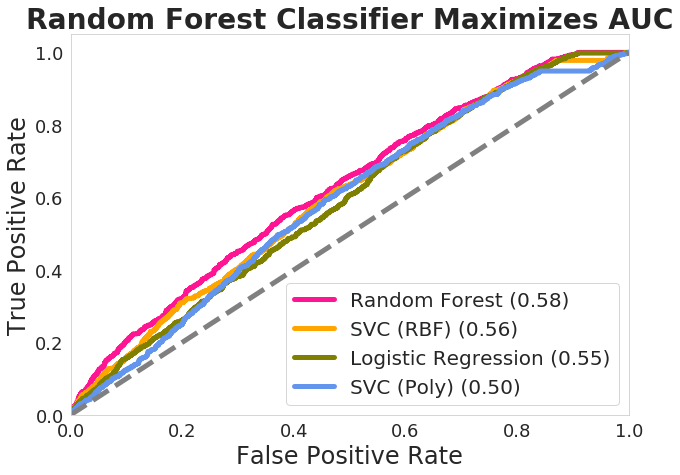

In [43]:
plt.style.use('seaborn-colorblind')
sns.set_style("whitegrid", {'axes.grid' : False})

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['deeppink','orange','olive','cornflowerblue'])

figure, ax = plt.subplots(figsize = (10,7))
#plt.figure(figsize=(10, 7))


for m in models_graph:
    if m['name'] == 'logreg' or m['name'] == 'rf' or m['name'] =='svm_rbf' or m['name'] =='svm_poly':
        model = m['model'] 
        y_predict = np.load('modelsF2/'+m['name']+'_ypreds.npy')
    
        fpr, tpr, thresholds = metrics.roc_curve(ytest, model.predict_proba(X_test_scaled)[:,1])
        if model == svm_poly:
            fpr = 1-fpr
            tpr = 1-tpr
        # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(ytest,model.predict(X_test_scaled))
        # Plot the computed values
        plt.plot(fpr, tpr, label='%s (%0.2f)' % (m['label'], auc))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1], color = 'gray', linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.setp(ax.lines, linewidth=5)
plt.xlabel('False Positive Rate', size = 24)
plt.ylabel('True Positive Rate', size = 24)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title('Random Forest Classifier Maximizes AUC', weight = 'bold', size = 28)
plt.legend(loc="lower right", prop = {'size': 20})
plt.savefig("graphs/ROCAUC.png", bbox_inches='tight')
plt.show();

***

**Correlated features from logistic regression**

In [110]:
coef_dict = {}
for coef, feat in zip(logreg.coef_[0],Xtrain.columns):
    coef_dict[feat] = coef
sorted(coef_dict.items(), key=lambda kv: kv[1], reverse=True)[0:10]

[('gender_male', 0.13546890700471856),
 ('num_sessions', 0.12756780415050537),
 ('first_device_type_2_mac desktop', 0.0728090709284054),
 ('gender_female', 0.07160256081137119),
 ('first_device_type_2_ipad', 0.06000110991394809),
 ('age', 0.03978261794028165),
 ('first_browser_2_ie', 0.03845576217103059),
 ('language_it', 0.027429724082392665),
 ('first_browser_2_chrome', 0.014265459750094306),
 ('language_fr', 0.010755559415014887)]

In [111]:
features = pd.DataFrame([coef_dict]).transpose().reset_index()
features.columns = ['feature','weight']


In [112]:
lang = features[features['feature'].str.contains("language")]
lang = lang[lang['feature'] != 'language_en']
lang['weight'].sum()

features = features.append({'feature': 'language_non_english',
                            'weight': lang['weight'].sum()}, ignore_index=True)

In [113]:
features['abs_weight'] = abs(features.weight)
features = features.sort_values(by='abs_weight', ascending = False).reset_index(drop=True)
features = features[features.feature != 'month_first_booking']
features[0:10]

,feature,weight,abs_weight
0,day_active_3.0,-0.149004,0.149004
1,gender_male,0.135469,0.135469
2,num_sessions,0.127568,0.127568
3,num_different_actions,-0.111161,0.111161
4,month_active_4.0,-0.110948,0.110948
5,first_device_type_2_mac desktop,0.072809,0.072809
6,gender_female,0.071603,0.071603
7,language_non_english,0.067342,0.067342
8,first_device_type_2_ipad,0.060001,0.060001
9,signup_app_2_moweb,-0.050122,0.050122


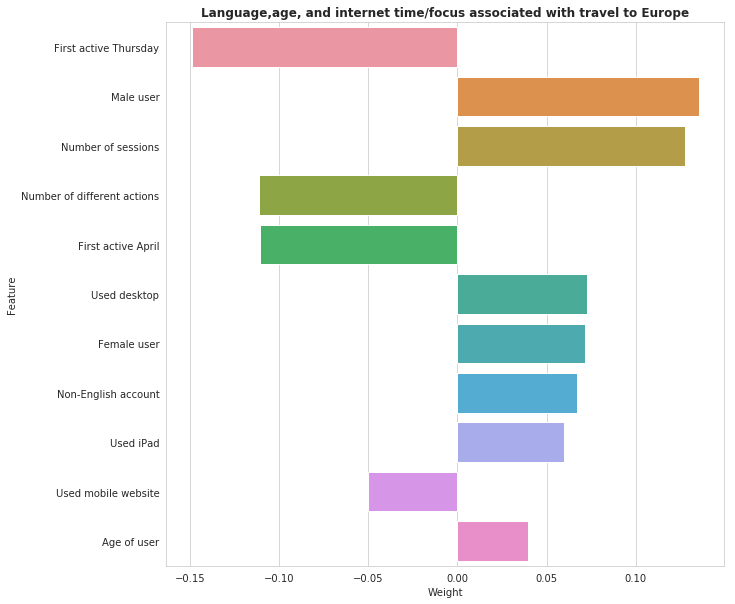

In [114]:
sns.set_style("whitegrid")
ftplot, ax = plt.subplots(figsize = (10,10))
ftplot = sns.barplot(y="feature", x="weight", orient="h", data=features[0:11])

y_lab = ['First active Thursday', 
         'Male user', 
         'Number of sessions', 
         'Number of different actions', 
         'First active April',
         'Used desktop',
         'Female user',
         'Non-English account',
         'Used iPad',
         'Used mobile website',
         'Age of user']

ax.set_xlabel('Weight')
ax.set_ylabel('Feature')
ax.set_title('Language,age, and internet time/focus associated with travel to Europe', weight='bold')

ax.set_yticklabels(labels=y_lab, ha='right');
axes = ftplot.axes
plt.savefig("graphs/logreg_features.png", bbox_inches='tight')
#axes.set_xlim(-.02,.02);

**Important features from random forest**

In [115]:
importances_dict = {}
for feature, importance in zip(Xtrain.columns, rf.feature_importances_):
    importances_dict[feature] = importance
sorted(importances_dict.items(), key=lambda kv: kv[1], reverse=True)[0:10]

[('secs_elapsed_std', 0.11675262344714768),
 ('num_sessions', 0.11559320102210376),
 ('age', 0.1141285691032105),
 ('secs_elapsed_mean', 0.11161479845672491),
 ('day_active_3.0', 0.0983911399113991),
 ('month_active_4.0', 0.083973110503857),
 ('num_different_actions', 0.08189867205747428),
 ('gender_male', 0.029818070054350755),
 ('first_device_type_2_mac desktop', 0.022141727436610272),
 ('gender_female', 0.0177875715350553)]

In [116]:
features = pd.DataFrame([importances_dict]).transpose().reset_index()
features.columns = ['feature','importance']

In [117]:
lang = features[features['feature'].str.contains("language")]
lang = lang[lang['feature'] != 'language_en']
lang['importance'].sum()

features = features.append({'feature': 'language_non_english',
                            'importance': lang['importance'].sum()}, ignore_index=True)

In [118]:
features = features.sort_values(by='importance', ascending = False).reset_index(drop=True)
features[0:5]

,feature,importance
0,secs_elapsed_std,0.116753
1,num_sessions,0.115593
2,age,0.114129
3,secs_elapsed_mean,0.111615
4,day_active_3.0,0.098391


In [ ]:
label = {'secs_elapsed_std': 'Seconds between sessions (std dev)',  
             'num_sessions':'Number of sessions', 
             'age':'Age of user',
             'secs_elapsed_mean':'Seconds between sessions (mean)', 
             'day_active_3.0':'First active Thursday',
             'month_active_4.0':'First active April',
             'num different_actions':'Number of different actions',
             'gender_male':'Male user',
             'first_device_type_2_mac desktop':'Used Mac desktop',
             'gender_female':'Female user',
             'language_non_english':'Non-English account'}
features = 

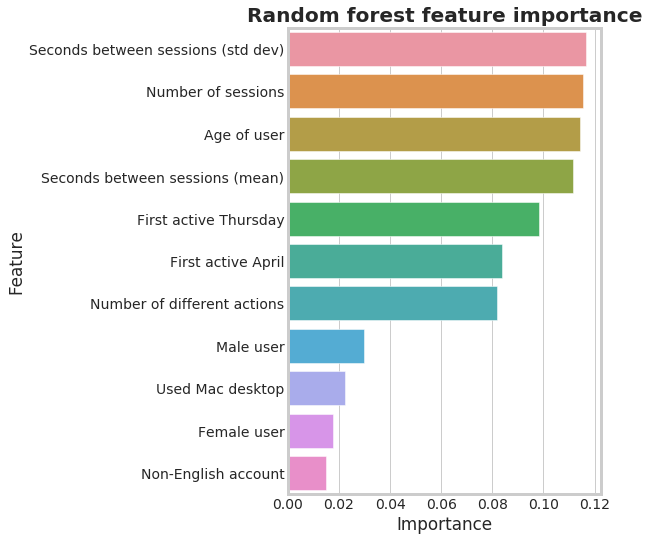

In [119]:
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
ftplot, ax = plt.subplots(figsize = (5,8))
ftplot = sns.barplot(y="feature", x="importance", 
            orient="h", data=features[0:11])

y_lab = ['Seconds between sessions (std dev)',  
         'Number of sessions', 
         'Age of user',
         'Seconds between sessions (mean)', 
         'First active Thursday',
         'First active April',
         'Number of different actions',
         'Male user',
         'Used Mac desktop',
         'Female user',
         'Non-English account'
         ]

ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Random forest feature importance', weight='bold')

ax.set_yticklabels(labels=y_lab, ha='right');
axes = ftplot.axes
plt.savefig("graphs/rf_importance.png", bbox_inches='tight')

**Change threshold for top model**

In [120]:
top_model = rf

In [121]:
pred_probas = {}
probs=np.arange(0.,1.05,0.05)
for p in probs:
    y_predict = top_model.predict_proba(X_test_scaled)[:,1] > p
    f2 = fbeta_score(ytest, y_predict, beta=2).round(3)
    pred_probas[p] = f2
pred_probas

{0.0: 0.631,
 0.05: 0.631,
 0.1: 0.652,
 0.15000000000000002: 0.652,
 0.2: 0.652,
 0.25: 0.652,
 0.30000000000000004: 0.652,
 0.35000000000000003: 0.652,
 0.4: 0.652,
 0.45: 0.651,
 0.5: 0.583,
 0.55: 0.117,
 0.6000000000000001: 0.006,
 0.65: 0.0,
 0.7000000000000001: 0.0,
 0.75: 0.0,
 0.8: 0.0,
 0.8500000000000001: 0.0,
 0.9: 0.0,
 0.9500000000000001: 0.0,
 1.0: 0.0}

**Toggle threshold**

In [122]:
y_predict = rf.predict_proba(X_test_scaled)[:,1]
y_predict

array([0.50532477, 0.4706952 , 0.50507232, ..., 0.54469946, 0.50569214,
       0.51592175])

In [153]:
t = 0.5
df = pd.DataFrame(y_predict)
df.columns = ['prob']
df = df.assign(ytest=ytest.values)
df.ytest = [int(x) for x in df.ytest]
df['ypred'] = np.where(df.eval("prob > "+str(t)), 1, 0)
df.head()

,prob,ytest,ypred
0,0.505325,0,1
1,0.470695,0,0
2,0.505072,0,1
3,0.524007,0,1
4,0.517490,1,1
